# Enhancing LSTMs With Character Embeddings For Named Entity Recognition

This is the fifth in my series about named entity recognition with python. If you haven’t seen the last four, have a look now. The last time we used a CRF-LSTM to model the sequence structure of our sentences. We used the LSTM on word level and applied word embeddings. While this approach is straight forward and often yields strong results there are some potential shortcomings. If we haven’t seen a word a prediction time, we have to encode it as unknown and have to infer it’s meaning by it’s surrounding words. Often word postfix or prefix contains a lot of information about the meaning of the word. Using this information is very important if you deal with texts that contain a lot of rare words and you expect a lot of unknown words at inference time. For example when you work with medical texts.

To encode the character-level information, we will use character embeddings and a LSTM to encode every word to an vector. We can use basically everything that produces a single vector for a sequence of characters that represent a word. You can also use a max-pooling architecture or a CNN or whatever works for you. Then we feed the vector to another LSTM together with the learned word embedding.

If you read the last posts about named entity recognition, you already know the dataset we’re going to use and the basics of the approach we take. So you might want to skip the first part.



## 1. Load the data

We start as always by loading the data.

In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv("data/ner_dataset.csv", encoding="latin1")

In [3]:
data = data.fillna(method="ffill")

In [4]:
data.tail(10)

,Sentence #,Word,POS,Tag
1048565,Sentence: 47958,impact,NN,O
1048566,Sentence: 47958,.,.,O
1048567,Sentence: 47959,Indian,JJ,B-gpe
1048568,Sentence: 47959,forces,NNS,O
1048569,Sentence: 47959,said,VBD,O
1048570,Sentence: 47959,they,PRP,O
1048571,Sentence: 47959,responded,VBD,O
1048572,Sentence: 47959,to,TO,O
1048573,Sentence: 47959,the,DT,O
1048574,Sentence: 47959,attack,NN,O


In [5]:
words = list(set(data["Word"].values))
n_words = len(words); n_words

35178

In [6]:
tags = list(set(data["Tag"].values))
n_tags = len(tags); n_tags

17

So we have 47959 sentences containing 35178 different words with 17 different tags. We use the SentenceGetter class from last post to retrieve sentences with their labels.

In [7]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [8]:
getter = SentenceGetter(data)

In [9]:
sent = getter.get_next()

This is how a sentence looks now.

In [10]:
print(sent)

[('Thousands', 'NNS', 'O'), ('of', 'IN', 'O'), ('demonstrators', 'NNS', 'O'), ('have', 'VBP', 'O'), ('marched', 'VBN', 'O'), ('through', 'IN', 'O'), ('London', 'NNP', 'B-geo'), ('to', 'TO', 'O'), ('protest', 'VB', 'O'), ('the', 'DT', 'O'), ('war', 'NN', 'O'), ('in', 'IN', 'O'), ('Iraq', 'NNP', 'B-geo'), ('and', 'CC', 'O'), ('demand', 'VB', 'O'), ('the', 'DT', 'O'), ('withdrawal', 'NN', 'O'), ('of', 'IN', 'O'), ('British', 'JJ', 'B-gpe'), ('troops', 'NNS', 'O'), ('from', 'IN', 'O'), ('that', 'DT', 'O'), ('country', 'NN', 'O'), ('.', '.', 'O')]


Okay, that looks like expected, now get all sentences.

In [11]:
sentences = getter.sentences

## 2. Prepare the tokens

Now we introduce dictionaries of words and tags.

In [13]:
max_len = 75
max_len_char = 10

In [14]:
word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1
word2idx["PAD"] = 0
idx2word = {i: w for w, i in word2idx.items()}
tag2idx = {t: i + 1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0
idx2tag = {i: w for w, i in tag2idx.items()}

In [15]:
print(word2idx["Obama"])
print(tag2idx["B-geo"])

7652
1


Now we map the sentences to a sequence of numbers and then pad the sequence. Note that we increased the index of the words by one to use zero as a padding value. This is done because we want to use the mask_zero parameter of the embedding layer to ignore inputs with value zero.

In [17]:
from keras.preprocessing.sequence import pad_sequences
X_word = [[word2idx[w[0]] for w in s] for s in sentences]

Using TensorFlow backend.


In [20]:
X_word = pad_sequences(maxlen=max_len, sequences=X_word, value=word2idx["PAD"], padding='post', truncating='post')

Now we have to generate a dictionary for the characters we want to use and create the sequence of characters for every token. Note that we, rather arbitrary, set max_len_char to 10. We could also use longer or shorter sequences. We could even use two sequences, one with the five first characters and one with the five last characters. In general we would like to avoid padding or cutting the character sequences for words. But since keras builds on tensorflow, we have to know the lengths of our input sequences at the beginning. The solution would be to use a framework like pyTorch or maybe the tensorflow eager execution.

In [21]:
chars = set([w_i for w in words for w_i in w])
n_chars = len(chars)
print(n_chars)

98


In [23]:
char2idx = {c: i + 2 for i, c in enumerate(chars)}
char2idx["UNK"] = 1
char2idx["PAD"] = 0

In [25]:
X_char = []
for sentence in sentences:
    sent_seq = []
    for i in range(max_len):
        word_seq = []
        for j in range(max_len_char):
            try:
                word_seq.append(char2idx.get(sentence[i][0][j]))
            except:
                word_seq.append(char2idx.get("PAD"))
        sent_seq.append(word_seq)
    X_char.append(np.array(sent_seq))

And we need to do the same mapping and padding for our tag sequence.

In [30]:
y = [[tag2idx[w[2]] for w in s] for s in sentences]

In [31]:
y = pad_sequences(maxlen=max_len, sequences=y, value=tag2idx["PAD"], padding='post', truncating='post')

We split in train and test set.

In [32]:
from sklearn.model_selection import train_test_split

In [33]:
X_word_tr, X_word_te, y_tr, y_te = train_test_split(X_word, y, test_size=0.1, random_state=2018)
X_char_tr, X_char_te, _, _ = train_test_split(X_char, y, test_size=0.1, random_state=2018)

## 3. Define the character embedding model

In [36]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Conv1D
from keras.layers import Bidirectional, concatenate, SpatialDropout1D, GlobalMaxPooling1D

The trick here is, to wrap the parts that should be applied to the characters in a TimeDistributed layer to apply the same layers to every character sequence.

In [37]:
# input and embedding for words
word_in = Input(shape=(max_len,))
emb_word = Embedding(input_dim=n_words + 2, output_dim=20,
                     input_length=max_len, mask_zero=True)(word_in)

# input and embeddings for characters
char_in = Input(shape=(max_len, max_len_char,))
emb_char = TimeDistributed(Embedding(input_dim=n_chars + 2, output_dim=10,
                           input_length=max_len_char, mask_zero=True))(char_in)
# character LSTM to get word encodings by characters
char_enc = TimeDistributed(LSTM(units=20, return_sequences=False,
                                recurrent_dropout=0.5))(emb_char)

# main LSTM
x = concatenate([emb_word, char_enc])
x = SpatialDropout1D(0.3)(x)
main_lstm = Bidirectional(LSTM(units=50, return_sequences=True,
                               recurrent_dropout=0.6))(x)
out = TimeDistributed(Dense(n_tags + 1, activation="softmax"))(main_lstm)

model = Model([word_in, char_in], out)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


## 4. Train the model

Now we can compile the model as always and look at the summary.

In [38]:
#model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])

In [47]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy")

In [48]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 75, 10)       0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 75)           0                                            
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 75, 10, 10)   1000        input_2[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 75, 20)       703600      input_1[0][0]                    
__________________________________________________________________________________________________
time_distr

In [49]:
history = model.fit([X_word_tr,
                     np.array(X_char_tr).reshape((len(X_char_tr), max_len, max_len_char))],
                    np.array(y_tr).reshape(len(y_tr), max_len, 1),
                    batch_size=32, epochs=10, validation_split=0.1, verbose=1)

Train on 38846 samples, validate on 4317 samples
Epoch 1/10
38846/38846 [==============================] - 183s 5ms/step - loss: 0.4360 - val_loss: 0.2009
Epoch 2/10
38846/38846 [==============================] - 177s 5ms/step - loss: 0.1614 - val_loss: 0.1312
Epoch 3/10
38846/38846 [==============================] - 183s 5ms/step - loss: 0.1159 - val_loss: 0.1112
Epoch 4/10
38846/38846 [==============================] - 191s 5ms/step - loss: 0.0979 - val_loss: 0.1041
Epoch 5/10
38846/38846 [==============================] - 189s 5ms/step - loss: 0.0884 - val_loss: 0.1010
Epoch 6/10
38846/38846 [==============================] - 188s 5ms/step - loss: 0.0819 - val_loss: 0.0995
Epoch 7/10
38846/38846 [==============================] - 191s 5ms/step - loss: 0.0770 - val_loss: 0.0986
Epoch 8/10
38846/38846 [==============================] - 194s 5ms/step - loss: 0.0734 - val_loss: 0.0980
Epoch 9/10
38846/38846 [==============================] - 184s 5ms/step - loss: 0.0703 - val_loss: 0.09

In [50]:
hist = pd.DataFrame(history.history)

In [53]:
hist

,val_loss,loss
0,0.200915,0.436005
1,0.131158,0.161376
2,0.111188,0.115944
3,0.104119,0.097893
4,0.100971,0.088376
5,0.099482,0.081875
6,0.098563,0.077044
7,0.098040,0.073444
8,0.098897,0.070256
9,0.099176,0.067381


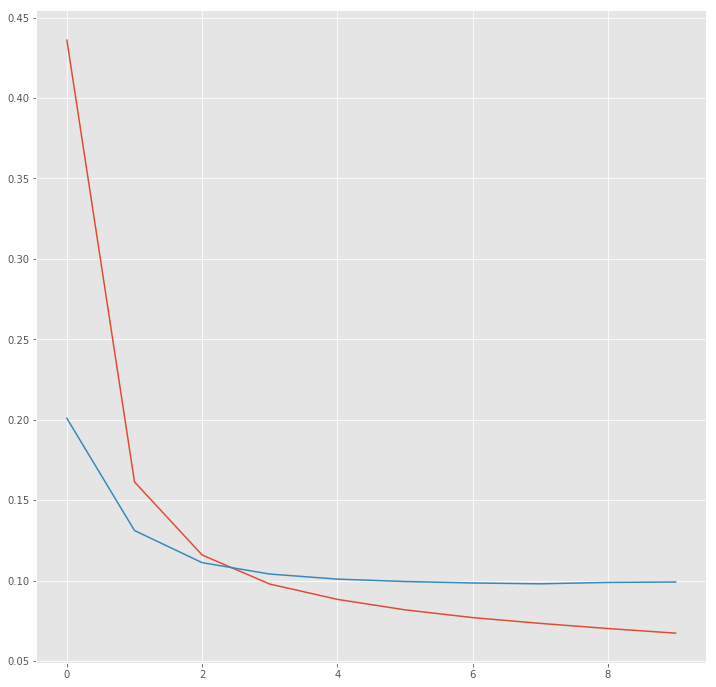

In [54]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.show()

Now look at some predictions.

In [55]:
y_pred = model.predict([X_word_te, np.array(X_char_te).reshape((len(X_char_te), max_len, max_len_char))])

In [56]:
i = 1925
p = np.argmax(y_pred[i], axis=-1)
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_word_te[i], y_te[i], p):
    if w != 0:
        print("{:15}: {:5} {}".format(idx2word[w], idx2tag[t], idx2tag[pred]))

Word           ||True ||Pred
On             : O     O
Monday         : B-tim B-tim
,              : O     O
British        : B-org B-org
Foreign        : I-org O
Secretary      : B-per B-per
Jack           : I-per I-per
Straw          : I-per I-per
said           : O     O
his            : O     O
government     : O     O
has            : O     O
found          : O     O
no             : O     O
evidence       : O     O
the            : O     O
Bush           : B-org B-per
administration : O     O
requested      : O     O
permission     : O     O
to             : O     O
fly            : O     O
terror         : O     O
suspects       : O     O
through        : O     O
Britain        : B-geo B-geo
or             : O     O
its            : O     O
airspace       : O     O
.              : O     O


This is an improvement to the previous posts and the architecture is straightforward. If you look closer, you will notice, that this kind of model performs much better on rare or unknown words.

In this post, you saw how you can use character embeddings to improve the performance of your named entity recognition model. Of course, there are many ways to improve this model. We haven’t tuned any parameters like dropout or learning rate. Also you can try using an CRF layer on top of this architecture or incorporate part of speech information. In the next post, I’m going to show you how you can achieve state-of-the-art performance in named entity recognition with the so called ELMo embeddings available on tensorhub.

I hope you enjoyed this post and learned something that you can apply in your daily work. Stay tuned for more and interesting posts in NLP and machine learning.